In [4]:
%pylab inline 
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2


Populating the interactive namespace from numpy and matplotlib


In [5]:
import pystan

In [473]:
import sys
sys.path.append('../src/')
from adaptivehmc import HMC, AdHMC, AdHMC_eps0
import diagnostics  as dg
import utils

In [ ]:
import arviz as az

# PyStan

In [8]:
sigma = 3
model_code_normal = """
parameters {
  real v; 
}


model {
v ~ normal(0, %s);
}
"""%sigma

def save_model(obj, filename):
    """Save compiled models for reuse."""
    import pickle
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_model(filename):
    """Reload compiled models for reuse."""
    import pickle
    return pickle.load(open(filename, 'rb'))


fname = '../scripts/compiled_models/normal1D_sig%s.pkl'%(sigma)

start = time.time()
try:
    sm_funnel = load_model(fname)
    print("Model loaded from %s"%fname, sm_funnel)
except Exception as e:
    print(e)
    sm_funnel = pystan.StanModel(model_code=model_code_normal)
    save_model(sm_funnel, fname)
    print("model saved in %s"%fname)

print("Time to make model : ", time.time()-start)


In [66]:
start = time.time()
stansamplesdict = sm_funnel.sampling(iter=10000, chains=1, algorithm="HMC", seed=100, n_jobs=1, warmup=100, 
                             init=1,  #[{'v':i[0], 'theta':i[1:]} for i in initstate.numpy()[0:1]],
                     control={"stepsize":0.1, 
                                "adapt_t0":False,
                                "adapt_delta":False,
                                "adapt_kappa":False,
                                "metric":"unit_e",
                              "int_time":5
                                })
end = time.time()
print(end - start)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration:  101 / 10000 [  1%]  (Sampling)
Iteration: 1100 / 10000 [ 11%]  (Sampling)
Iteration: 2100 / 10000 [ 21%]  (Sampling)
Iteration: 3100 / 10000 [ 31%]  (Sampling)
Iteration: 4100 / 10000 [ 41%]  (Sampling)
Iteration: 5100 / 10000 [ 51%]  (Sampling)
Iteration: 6100 / 10000 [ 61%]  (Sampling)
Iteration: 7100 / 10000 [ 71%]  (Sampling)
Iteration: 8100 / 10000 [ 81%]  (Sampling)
Iteration: 9100 / 10000 [ 91%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0 seconds (Warm-up)
               0.36 seconds (Sampling)
               0.36 seconds (Total)

0.3798787593841553


In [68]:
stansamples = stansamplesdict.extract()
stansamples.pop('lp__')
stansamples = np.array([stansamples[i] for i in stansamples.keys()])


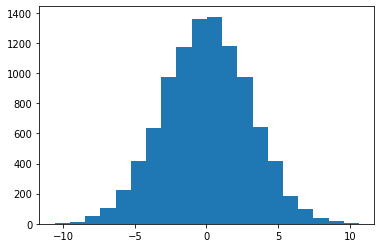

In [70]:
plt.hist(stansamples[0], bins=20);


# Pystan hmc

In [38]:
pyV = stansamples.log_prob
pyV_g = stansamples.grad_log_prob

In [432]:
# hmc = AdHMC(stansamples.log_prob, stansamples.grad_log_prob)
pyV = stansamples.log_prob
pyV_g = stansamples.grad_log_prob

hmc = HMC(stansamplesdict.log_prob, stansamplesdict.grad_log_prob)
qq = np.random.normal(size=stansamples[..., 0].size)
pp = np.random.normal(size=qq.size).reshape(qq.shape).astype(qq.dtype)

Nleap = 100
eps = 1.0
hmccounts = []
hmcsamples = []
for i in range(5000):
    x = hmc.hmc_step(qq, Nleap, eps)
    hmcsamples.append(x[0])
    hmccounts.append(x[-1])
    qq = x[0]
    
hmcsamples = np.array(hmcsamples).T
hmccounts = np.array(hmccounts).T
# def step(x):
#     return  hmc.hmc_step(x, 0, smin=smin, smax=smax, ratios=[0.9, 1.0, 1/0.9], Tint=Tint, normprob=0)



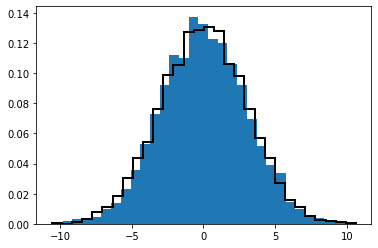

In [435]:
plt.hist(hmcsamples[0], bins=30, density=True)
plt.hist(stansamples[0], bins=30, density=True, lw=2, histtype='step', color='k');

## ADHMC

In [516]:
adhmc = AdHMC(stansamplesdict.log_prob, stansamplesdict.grad_log_prob)
qq = np.random.normal(size=stansamples[..., 0].size)
pp = np.random.normal(size=qq.size).reshape(qq.shape).astype(qq.dtype)

Nleap = 100

adhmcsamples = []
acc, probs, checks, counts = [], [], [], []
for i in range(1000):
    x  = adhmc.hmc_step(qq, Nleap, pwts0 = [0.9, 1.1], smin=0.5, smax=10, logeps=True)
#     x  = adhmc.hmc_step(qq, Nleap, ratios=[0.9, 1/0.9], pwts0 = [0.9, 1.1], smin=0.5, smax=10, logeps=True)
    qq = x[0]
    adhmcsamples.append(qq)
    acc.append(x[2])
    probs.append(x[3])
    checks.append(x[4])
    counts.append(x[5])
    

adhmcsamples = np.array(adhmcsamples).T
probs = np.array(probs).T
acc = np.array(acc).T
checks = np.array(checks)
counts = np.array(counts).T
print((acc == 1).sum()/acc.size)

../src/adaptivehmc.py:290: RuntimeWarning: invalid value encountered in true_divide
  pf /= pf.sum()
../src/adaptivehmc.py:281: RuntimeWarning: overflow encountered in exp
  pH = np.exp(H1 - Hs[-1])
../src/adaptivehmc.py:314: RuntimeWarning: overflow encountered in exp
  pH =  np.exp(H1 - Hsb[-1])


0.656


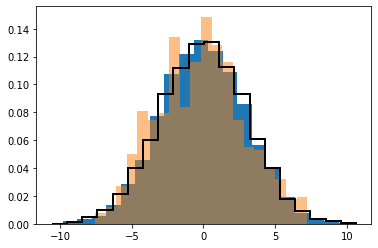

In [517]:
plt.hist(hmcsamples[0], bins=20, density=True);
plt.hist(adhmcsamples[0], bins=20, density=True, alpha=0.5)
plt.hist(stansamples[0], bins=20, density=True, lw=2, histtype='step', color='k');

Text(0.5, 0, 'starting step size')

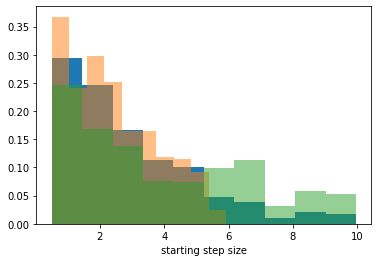

In [518]:
plt.hist(checks[:, -1, 0], density=True)
plt.xlabel('starting step size')
plt.hist(checks[acc==1, -1, 0], density=True, alpha=0.5)
plt.xlabel('starting step size')
plt.hist(checks[acc!=1, -1, 0], density=True, alpha=0.5)
plt.xlabel('starting step size')


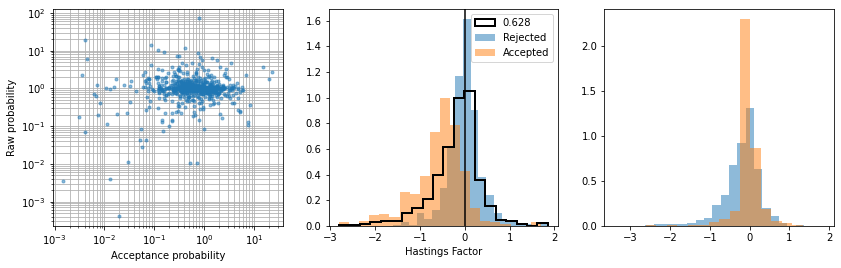

In [590]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.plot(probs[0][probs[0] > 1e-3], probs[1][probs[0] > 1e-3], '.', alpha=0.5)
plt.loglog()
plt.grid(which='both')
plt.xlabel('Acceptance probability')
plt.ylabel('Raw probability')
plt.subplot(132)
bump = (probs[2] > 0.5).sum()/probs[2].size
plt.hist(np.log10(probs[2][probs[2] > 1e-3]), bins=20, density=True, label=bump, lw=2, histtype='step', color='k')
plt.hist(np.log10(probs[2][acc == 1]), bins=20, density=True, label='Rejected', alpha=0.5)
plt.hist(np.log10(probs[2][(acc !=1) & (probs[2] > 1e-3)]), bins=20, density=True, label='Accepted', alpha=0.5)
plt.axvline(0, color='k')
plt.xlabel('Hastings Factor')
plt.legend()
plt.subplot(133)
plt.hist(np.log10(probs[0][probs[0]>1e-3]), density=True, bins=20, alpha=0.5)
plt.hist(np.log10(probs[1][probs[0]>1e-3]), density=True, bins=20, alpha=0.5);

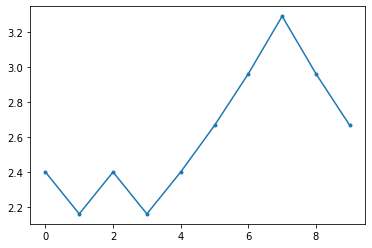

In [520]:
ii = np.random.randint(1000)
plt.plot(checks[ii, -1], marker='.')

In [530]:
epsthresh = 5
idx = np.where((checks[:, -1] > epsthresh))[0] ##indices where stpesize > 5 and not at initial proposal
traj = checks[idx[np.where(checks[:, -1] > epsthresh)[1] > 0], -1]
# plt.plot(traj.T)

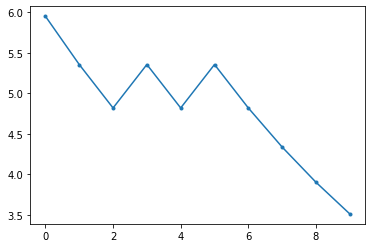

In [531]:
ii = np.random.randint(traj.shape[0])
plt.plot(traj[ii], marker='.')

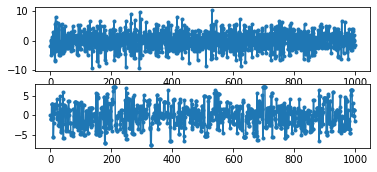

In [523]:
imin, imax = None, 1000
plt.subplot(311)
plt.plot(hmcsamples[ 0, imin:imax], marker='.')
plt.subplot(312)
plt.plot(adhmcsamples[ 0, imin:imax], marker='.')
# plt.subplot(313)
# acc2 = acc.copy()
# acc2[acc2 == 100] = 0
# plt.plot(acc2[imin:imax], marker='.')

In [524]:
utils.get_rcc(hmcsamples.reshape(-1, 1, 1))[1], utils.get_rcc(adhmcsamples.reshape(-1, 1, 1))[1]

(array([[2]]), array([[4]]))

(0.0, 10.0)

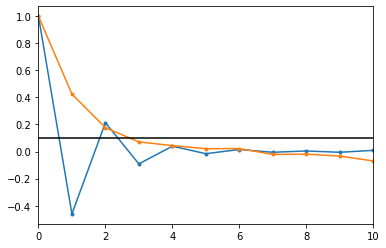

In [525]:
plt.plot(az.autocorr(hmcsamples[0]), marker='.')
plt.plot(az.autocorr(adhmcsamples[0]), marker='.')
plt.axhline(0.1, color='k')
plt.xlim(0, 10)

## ADHMC_eps0

In [542]:
epshmc = AdHMC_eps0(stansamplesdict.log_prob, stansamplesdict.grad_log_prob)
qq = np.random.normal(size=stansamples[..., 0].size)
pp = np.random.normal(size=qq.size).reshape(qq.shape).astype(qq.dtype)

Nleap = 100

epshmcsamples = []
acceps, probseps, checkseps, countseps = [], [], [], []
for i in range(1000):
    x  = epshmc.hmc_step(qq, Nleap,  smin=0.5, smax=10)
    qq = x[0]
    epshmcsamples.append(qq)
    acceps.append(x[2])
    probseps.append(x[3])
    checkseps.append(x[4])
    countseps.append(x[5])
    

epshmcsamples = np.array(epshmcsamples).T
probseps = np.array(probseps).T
acceps = np.array(acceps).T
checkseps = np.array(checkseps)
countseps = np.array(countseps).T
print((acc == 1).sum()/acc.size)

../src/adaptivehmc.py:120: RuntimeWarning: overflow encountered in exp
  pp = np.exp(H0 - Hs) * pwts
../src/adaptivehmc.py:123: RuntimeWarning: invalid value encountered in true_divide
  pp /= pp.sum()


0.656


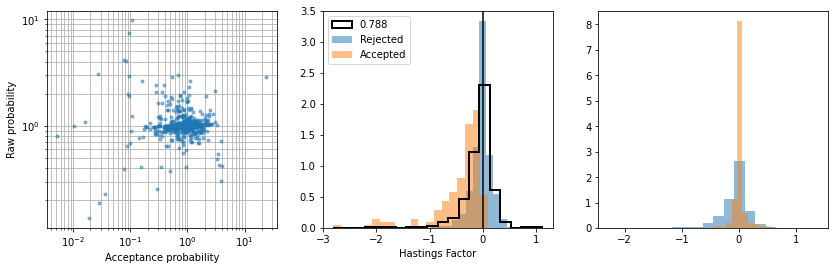

In [546]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.plot(probseps[0][probseps[0]> 1e-3], probseps[1][probseps[0]> 1e-3], '.', alpha=0.5)
plt.loglog()
plt.grid(which='both')
plt.xlabel('Acceptance probability')
plt.ylabel('Raw probability')
plt.subplot(132)
bump = (probseps[2] > 0.5).sum()/probseps[2].size
plt.hist(np.log10(probseps[2][probseps[2] > 1e-3]), bins=20, density=True, label=bump, lw=2, histtype='step', color='k')
plt.hist(np.log10(probseps[2][acceps == 1]), bins=20, density=True, label='Rejected', alpha=0.5)
plt.hist(np.log10(probseps[2][(acceps !=1) & (probseps[2] > 1e-3)]), bins=20, density=True, label='Accepted', alpha=0.5)
plt.axvline(0, color='k')
plt.xlabel('Hastings Factor')
plt.legend()
plt.subplot(133)
plt.hist(np.log10(probseps[0][probseps[0]>1e-3]), density=True, bins=20, alpha=0.5)
plt.hist(np.log10(probseps[1][probseps[0]>1e-3]), density=True, bins=20, alpha=0.5);

(0.0, 10.0)

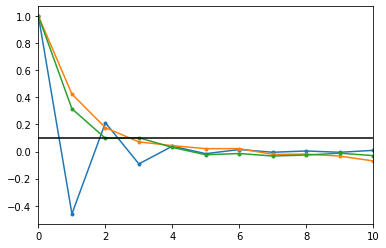

In [547]:
plt.plot(az.autocorr(hmcsamples[0]), marker='.')
plt.plot(az.autocorr(adhmcsamples[0]), marker='.')
plt.plot(az.autocorr(epshmcsamples[0]), marker='.')
plt.axhline(0.1, color='k')
plt.xlim(0, 10)

# Funnel

In [548]:
ndim = 5
fname = '../scripts/compiled_models/funnel_%ddim.pkl'%(ndim)

start = time.time()
try:
    sm_funnel = load_model(fname)
    print("Model loaded from %s"%fname, sm_funnel)
except Exception as e:
    print(e)
    sm_funnel = pystan.StanModel(model_code=model_code_normal)
    save_model(sm_funnel, fname)
    print("model saved in %s"%fname)

print("Time to make model : ", time.time()-start)


Model loaded from ../scripts/compiled_models/funnel_5dim.pkl StanModel object 'anon_model_b03fa6b45483d9931e9b94777761ffac' coded as follows:

    parameters {
    real v; 
    vector[4] theta;
    }
    
    
    model {
    v ~ normal(0, 3);
    theta ~ normal(0, exp(v/2));
    }
    
Time to make model :  0.12446069717407227


In [741]:
start = time.time()
stansamplesdict = sm_funnel.sampling(iter=5000, chains=1, algorithm="HMC", seed=100, n_jobs=1, warmup=1, 
                             init=1,  #[{'v':i[0], 'theta':i[1:]} for i in initstate.numpy()[0:1]],
                     control={"stepsize":0.02, 
                                "adapt_t0":False,
                                "adapt_delta":False,
                                "adapt_kappa":False,
                                "metric":"unit_e",
                              "int_time":5
                                })
end = time.time()
print(end - start)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 5000 [  0%]  (Warmup)
Iteration:    2 / 5000 [  0%]  (Sampling)
Iteration:  501 / 5000 [ 10%]  (Sampling)
Iteration: 1001 / 5000 [ 20%]  (Sampling)
Iteration: 1501 / 5000 [ 30%]  (Sampling)
Iteration: 2001 / 5000 [ 40%]  (Sampling)
Iteration: 2501 / 5000 [ 50%]  (Sampling)
Iteration: 3001 / 5000 [ 60%]  (Sampling)
Iteration: 3501 / 5000 [ 70%]  (Sampling)
Iteration: 4001 / 5000 [ 80%]  (Sampling)
Iteration: 4501 / 5000 [ 90%]  (Sampling)
Iteration: 5000 / 5000 [100%]  (Sampling)

 Elapsed Time: 0 seconds (Warm-up)
               1.25 seconds (Sampling)
               1.25 seconds (Total)

1.2612109184265137


In [742]:
stansamples = stansamplesdict.extract()
stansamples.pop('lp__')
stansamples = np.vstack([stansamples[i].T for i in stansamples.keys()])


In [654]:
# plt.hist(stansamples[3])

In [669]:
# hmc = AdHMC(stansamples.log_prob, stansamples.grad_log_prob)
pyV = stansamplesdict.log_prob
pyV_g = stansamplesdict.grad_log_prob

hmc = HMC(stansamplesdict.log_prob, stansamplesdict.grad_log_prob)
qq = np.random.normal(size=stansamples[..., 0].size)
pp = np.random.normal(size=qq.size).reshape(qq.shape).astype(qq.dtype)

Nleap = 50
eps = 0.01
hmccounts = []
hmcsamples = []
for i in range(5000):
    x = hmc.hmc_step(qq, Nleap, eps)
    hmcsamples.append(x[0])
    hmccounts.append(x[-1])
    qq = x[0]
    
hmcsamples = np.array(hmcsamples).T
hmccounts = np.array(hmccounts).T
# def step(x):
#     return  hmc.hmc_step(x, 0, smin=smin, smax=smax, ratios=[0.9, 1.0, 1/0.9], Tint=Tint, normprob=0)



# AdHMC

In [725]:
adhmc = AdHMC(stansamplesdict.log_prob, stansamplesdict.grad_log_prob)
qq = np.random.normal(size=stansamples[..., 0].size)
pp = np.random.normal(size=qq.size).reshape(qq.shape).astype(qq.dtype)

Nleap = 50

adhmcsamples = []
acc, probs, checks, counts = [], [], [], []
for i in range(5000):
#     x  = adhmc.hmc_step(qq, Nleap, nleap=5, smin=0.01, smax=1, logeps=True)
    x  = adhmc.hmc_step(qq, Nleap, nleap=5, pwts0 = [0.9, 1.1], smin=0.01, smax=1, logeps=True)
#     x  = adhmc.hmc_step(qq, Nleap, pwts0 = [0.9, 1.1], smin=0.01, smax=1, logeps=True)
#     x  = adhmc.hmc_step(qq, Nleap, ratios=[0.9, 1/0.9], pwts0 = [0.9, 1.1], smin=0.01, smax=1, logeps=True)
    qq = x[0]
    adhmcsamples.append(qq)
    acc.append(x[2])
    probs.append(x[3])
    checks.append(x[4])
    counts.append(x[5])
    

adhmcsamples = np.array(adhmcsamples).T
probs = np.array(probs).T
acc = np.array(acc).T
checks = np.array(checks)
counts = np.array(counts).T
print((acc == 1).sum()/acc.size)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variab

../src/adaptivehmc.py:291: RuntimeWarning: invalid value encountered in true_divide
  pf /= pf.sum()


Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variab

../src/adaptivehmc.py:315: RuntimeWarning: overflow encountered in exp
  pH =  np.exp(H1 - Hsb[-1])
../src/adaptivehmc.py:322: RuntimeWarning: invalid value encountered in true_divide
  pb /= pb.sum()
../src/adaptivehmc.py:343: RuntimeWarning: invalid value encountered in double_scalars
  toret = [[prob, prob/hastings_factor, hastings_factor], np.stack([pf_den, pb_num, eps]), [self.Hcount, self.Vgcount, self.leapcount]]



Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random variable is -nan, but must not be nan!  (in 'unknown file name' at line 9)

Exception: normal_lpdf: Random varia

../src/adaptivehmc.py:282: RuntimeWarning: overflow encountered in exp
  pH = np.exp(H1 - Hs[-1])


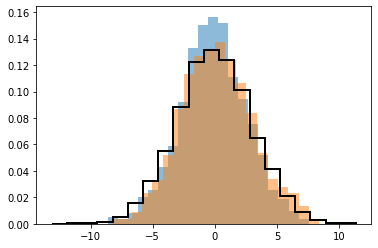

In [743]:
nbins = 20 
# plt.hist(hmcsamples[0], bins=20, density=True, alpha=0.5)
plt.hist(adhmcsamples[0], bins=nbins, density=True, alpha=0.5)
plt.hist(stansamples[0], bins=nbins, density=True, alpha=0.5)
plt.hist(np.random.normal(0, 3, size=10000), density=True, lw=2, histtype='step', color='k', bins=nbins);

(array([0.24397041, 0.3458821 , 0.45551438, 0.51110257, 0.59602898,
        0.59139663, 0.73499947, 0.74117594, 0.57749958, 0.25323511]),
 array([-1.98835416, -1.79036592, -1.59237769, -1.39438945, -1.19640122,
        -0.99841299, -0.80042475, -0.60243652, -0.40444828, -0.20646005,
        -0.00847181]),
 <BarContainer object of 10 artists>)

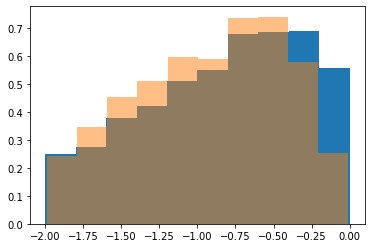

In [744]:
plt.hist(np.log10(checks[:, -1, 0]), density=True)
plt.hist(np.log10(checks[acc==1, -1, 0]), density=True, alpha=0.5)
# plt.hist(np.log10(checks[acc!=1, -1, 0]), density=True, alpha=0.5)
# plt.xlabel('starting step size')


array([-3.17409014, -3.17409014, -2.42268206])

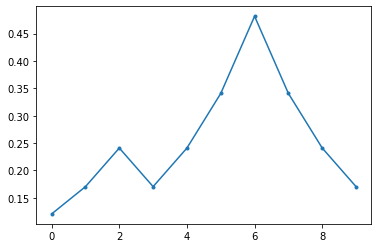

In [745]:
ii = np.random.randint(1000)
plt.plot(checks[ii, -1], marker='.')
adhmcsamples[0, ii-1:ii+2]

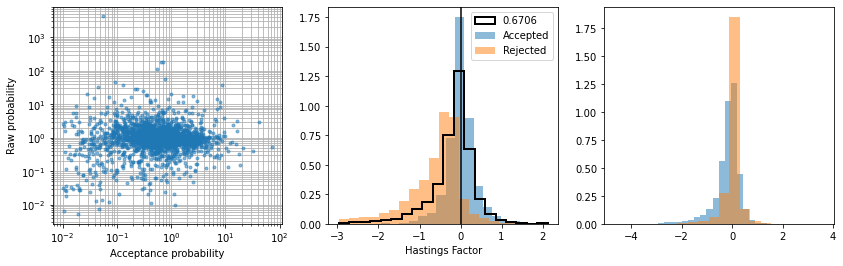

In [746]:

plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.plot(probs[0][probs[0] > 1e-2], probs[1][probs[0] > 1e-2], '.', alpha=0.5)
plt.loglog()
plt.grid(which='both')
plt.xlabel('Acceptance probability')
plt.ylabel('Raw probability')
plt.subplot(132)
bump = (probs[2] > 0.5).sum()/probs[2].size
plt.hist(np.log10(probs[2][probs[2] > 1e-3]), bins=20, density=True, label=bump, lw=2, histtype='step', color='k')
plt.hist(np.log10(probs[2][acc == 1]), bins=20, density=True, label='Accepted', alpha=0.5)
plt.hist(np.log10(probs[2][(acc !=1) & (probs[2] > 1e-3)]), bins=20, density=True, label='Rejected', alpha=0.5)
plt.axvline(0, color='k')
plt.xlabel('Hastings Factor')
plt.legend()
plt.subplot(133)
plt.hist(np.log10(probs[0][probs[0]>1e-3]), density=True, bins=20, alpha=0.5)
plt.hist(np.log10(probs[1][probs[0]>1e-3]), density=True, bins=20, alpha=0.5);

<ipython-input-752-df72de7c6ccd>:11: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


(0.0, 500.0)

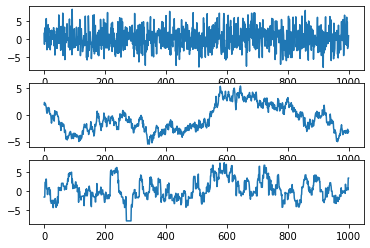

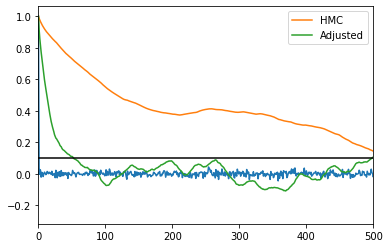

In [752]:
imin, imax = None, 1000
plt.subplot(311)
plt.plot(stansamples[ 0, imin:imax], marker='')
plt.subplot(312)
plt.plot(hmcsamples[ 0, imin:imax], marker='')
plt.subplot(313)
plt.plot(adhmcsamples[ 0, imin:imax], marker='')
# acc2 = acc.copy()
# acc2[acc2 == 100] = 0
# plt.plot(acc2[imin:imax], marker='.')
plt.show()

plt.figure()
plt.plot(az.autocorr(stansamples[0]), marker='')
plt.plot(az.autocorr(hmcsamples[0]), marker='', label='HMC')
plt.plot(az.autocorr(adhmcsamples[0]), marker='', label='Adjusted')
plt.legend()
plt.axhline(0.1, color='k')
plt.xlim(0, 500)


In [749]:
adhmcsamples.mean(axis=1), adhmcsamples.std(axis=1)


(array([-0.09802322, -0.06157949,  0.09917419,  0.17204025, -0.09775842]),
 array([2.6529681 , 3.38923004, 3.73362846, 3.76747147, 4.07556822]))

In [750]:
stansamples.mean(axis=1), stansamples.std(axis=1)


(array([ 0.15455775, -0.30463789,  1.06208533, -0.66314759, -0.18273475]),
 array([2.88051286, 4.69736137, 6.69437433, 7.44059489, 5.78069791]))

In [734]:
counts

array([[ 51,  51,  51, ...,  51,  51,  51],
       [208, 208, 208, ..., 208, 208, 208],
       [ 48,  48,  48, ...,  48,  48,  48]])

In [735]:
hmccounts

array([[ 2,  2,  2, ...,  2,  2,  2],
       [51, 51, 51, ..., 51, 51, 51],
       [ 1,  1,  1, ...,  1,  1,  1]])

<ipython-input-763-e9ed30b6c48f>:12: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


(0.0, 100.0)

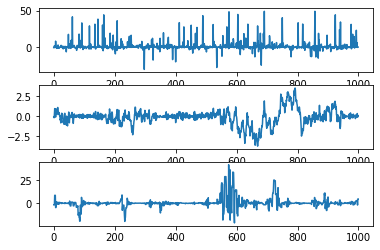

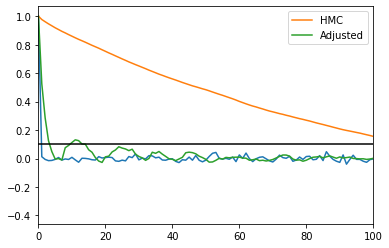

In [763]:
imin, imax = None, 1000
ii = 2
plt.subplot(311)
plt.plot(stansamples[ii, imin:imax], marker='')
plt.subplot(312)
plt.plot(hmcsamples[ ii, imin:imax], marker='')
plt.subplot(313)
plt.plot(adhmcsamples[ii, imin:imax], marker='')
# acc2 = acc.copy()
# acc2[acc2 == 100] = 0
# plt.plot(acc2[imin:imax], marker='.')
plt.show()

plt.figure()
plt.plot(az.autocorr(stansamples[ii]), marker='')
plt.plot(az.autocorr(hmcsamples[ii]), marker='', label='HMC')
plt.plot(az.autocorr(adhmcsamples[ii]), marker='', label='Adjusted')
plt.legend()
plt.axhline(0.1, color='k')
plt.xlim(0, 100)


In [757]:
stansamples.shape

(5, 4999)

In [761]:
ii = 1
utils.get_rcc(stansamples[ii].reshape(-1, 1, 1))[1], utils.get_rcc(adhmcsamples[ii].reshape(-1, 1, 1))[1]

(array([[3]]), array([[4]]))